In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2
import numpy as np
from torchvision.transforms.functional import to_pil_image
import seaborn as sns

In [125]:
class TrafficDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if f.endswith('.jpg')]
        self.images.sort()  # sorted by time

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.images[idx])
        image = read_image(img_name)
        timestamp = pd.to_datetime(self.images[idx].split('.')[0], format='%Y-%m-%dT%H-%M-%S')
        if self.transform:
            image = self.transform(image)
        timestamp = pd.to_datetime(self.images[idx].split('.')[0], format='%Y-%m-%dT%H-%M-%S')
        # Decrease the time by three hours
        timestamp -= pd.Timedelta(hours=3)
        timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')  # Convert to string
        print(timestamp)
        return image, timestamp

dataset = TrafficDataset('./traffic', transform=transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ConvertImageDtype(torch.float)
]))
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)


In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    None,  
    'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', None,  
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', None, None,  
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', None, 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    None, 'dining table', None, None, 'toilet', None, 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', None,
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [4]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
# Move model to GPU if available
device = torch.device("mps" if torch.cuda.is_available() else "cpu")# mps for Apple M1/M2
model.to(device)
model.eval()  # Set the model to evaluation mode


/Users/abdulazizalyahya/.pyenv/versions/3.8.18/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/abdulazizalyahya/.pyenv/versions/3.8.18/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# object categories 
interested_objects = ['car', 'bus','person','truck']
object_counts = defaultdict(list)

print("Starting processing...")
borderline_y = 240  # the y-coordinate of the borderline

for batch_idx, (images, timestamps) in enumerate(dataloader):
    print(f"Processing batch {batch_idx+1}/{len(dataloader)}")
    images = list(image.to(device) for image in images)
    
    with torch.no_grad():
        outputs = model(images)
    
    print(f"Batch {batch_idx+1}: Model has outputted results.")
    
    confidence_threshold = 0.8 
    
    for i, output in enumerate(outputs):
        count = {obj: 0 for obj in interested_objects}
        for label, box, score in zip(output['labels'], output['boxes'], output['scores']):
            if score > confidence_threshold:
                if label.item() < len(COCO_INSTANCE_CATEGORY_NAMES):
                    label_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
                    if label_name in interested_objects:
                        x1, y1, x2, y2 = box.int().tolist()
                        if y1 > borderline_y or y2 > borderline_y:
                            count[label_name] += 1

        
        # the counts for the current image
        print(f"Image {i+1} in batch {batch_idx+1}: Object counts - {count}")
        
        for obj in interested_objects:
            object_counts[obj].append((timestamps[i], count[obj]))
            
    print(f"Completed processing batch {batch_idx+1}.")
    
print("Completed all processing.")

#print a summary of counts for debugging
print("Summary of object counts:")
for obj, counts in object_counts.items():
    print(f"{obj}: Total count over all images - {sum([count for _, count in counts])}")


Starting processing...
2021-05-01 00:01:05
2021-05-01 00:02:47
2021-05-01 00:04:28
2021-05-01 00:06:10
2021-05-01 00:07:51
2021-05-01 00:09:33


/Users/abdulazizalyahya/.pyenv/versions/3.8.18/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2021-05-01 00:11:14
2021-05-01 00:12:56
Processing batch 1/701
Batch 1: Model has outputted results.
Image 1 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Image 2 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Image 3 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Image 4 in batch 1: Object counts - {'car': 1, 'bus': 0, 'person': 0, 'truck': 0}
Image 5 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Image 6 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Image 7 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Image 8 in batch 1: Object counts - {'car': 0, 'bus': 0, 'person': 0, 'truck': 0}
Completed processing batch 1.
2021-05-01 00:14:37
2021-05-01 00:16:17
2021-05-01 00:17:58
2021-05-01 00:19:40
2021-05-01 00:21:21
2021-05-01 00:23:02
2021-05-01 00:24:44
2021-05-01 00:26:26
Processing batch 2/701
Batch 2: Model has outputted r

    hour      count
0      0   6.857143
1      1   2.857143
2      2   1.285714
3      3   1.571429
4      4   0.857143
5      5   1.000000
6      6   0.285714
7      7   7.857143
8      8  21.000000
9      9  16.714286
10    10  27.285714
11    11  23.857143
12    12  32.428571
13    13  40.714286
14    14  39.142857
15    15  46.285714
16    16  39.142857
17    17  34.714286
18    18  37.285714
19    19  29.142857
20    20  19.571429
21    21  16.166667
22    22  13.166667
23    23   8.500000


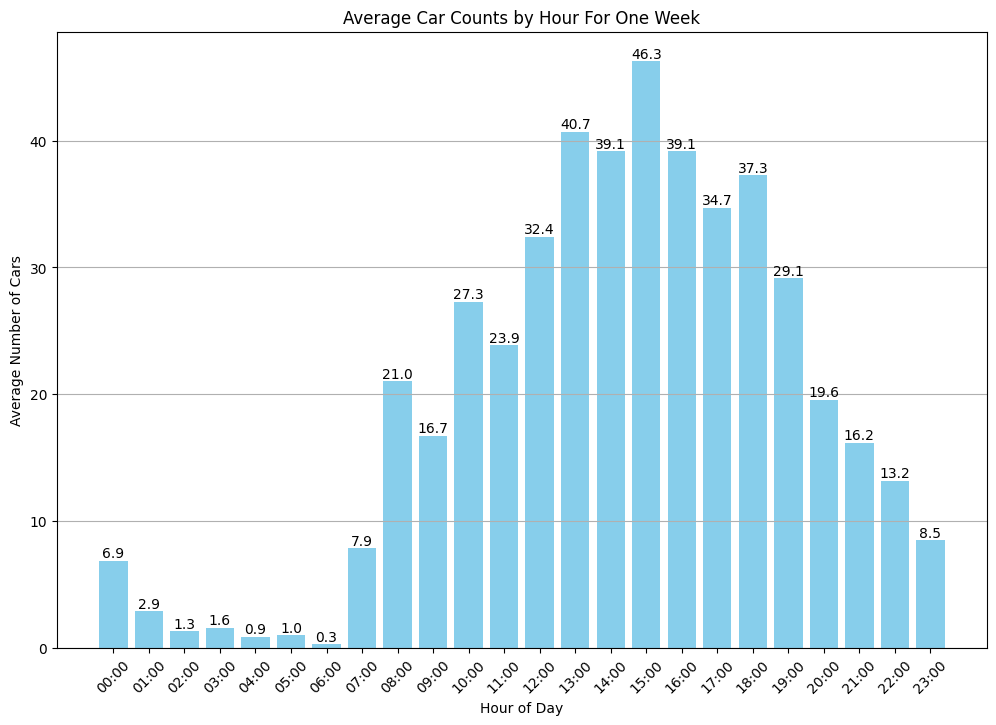

    hour     count
0      0  1.285714
1      1  0.857143
2      2  1.142857
3      3  0.142857
4      4  0.000000
5      5  0.285714
6      6  1.142857
7      7  2.571429
8      8  3.857143
9      9  4.714286
10    10  4.571429
11    11  4.428571
12    12  4.000000
13    13  4.857143
14    14  5.285714
15    15  5.857143
16    16  3.000000
17    17  4.142857
18    18  3.857143
19    19  3.428571
20    20  3.142857
21    21  2.333333
22    22  1.500000
23    23  1.500000


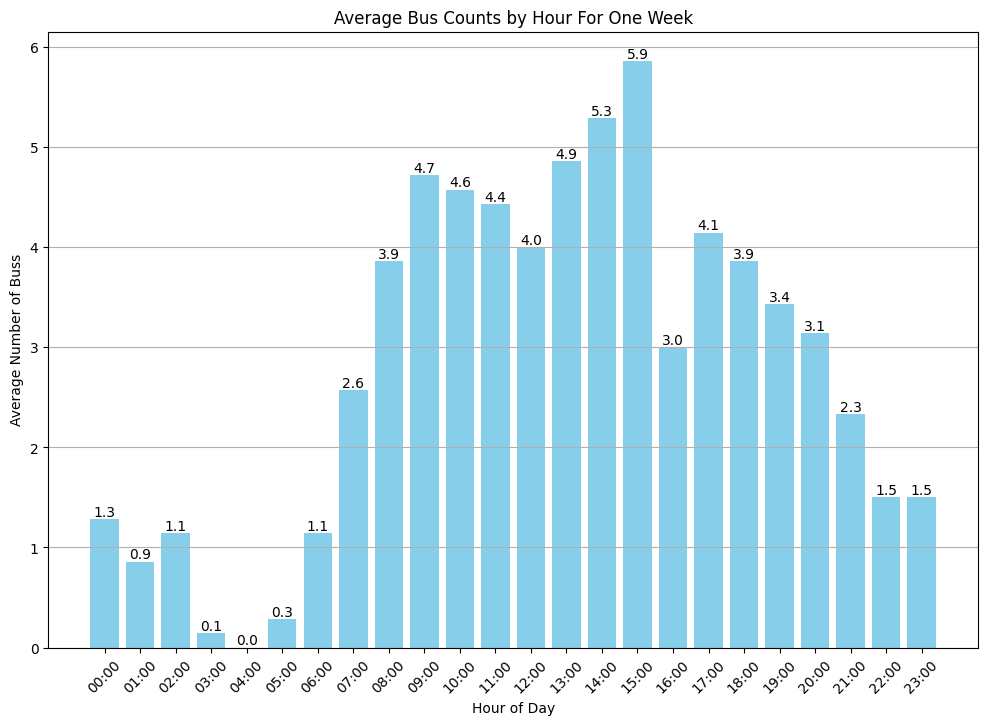

    hour      count
0      0   2.428571
1      1   1.428571
2      2   1.714286
3      3   1.000000
4      4   0.857143
5      5   0.428571
6      6   0.285714
7      7   1.428571
8      8   5.428571
9      9   8.571429
10    10   9.428571
11    11  14.285714
12    12  14.285714
13    13  26.000000
14    14  22.857143
15    15  23.428571
16    16  27.571429
17    17  17.571429
18    18  21.571429
19    19  17.142857
20    20  13.571429
21    21  11.333333
22    22   3.166667
23    23   3.666667


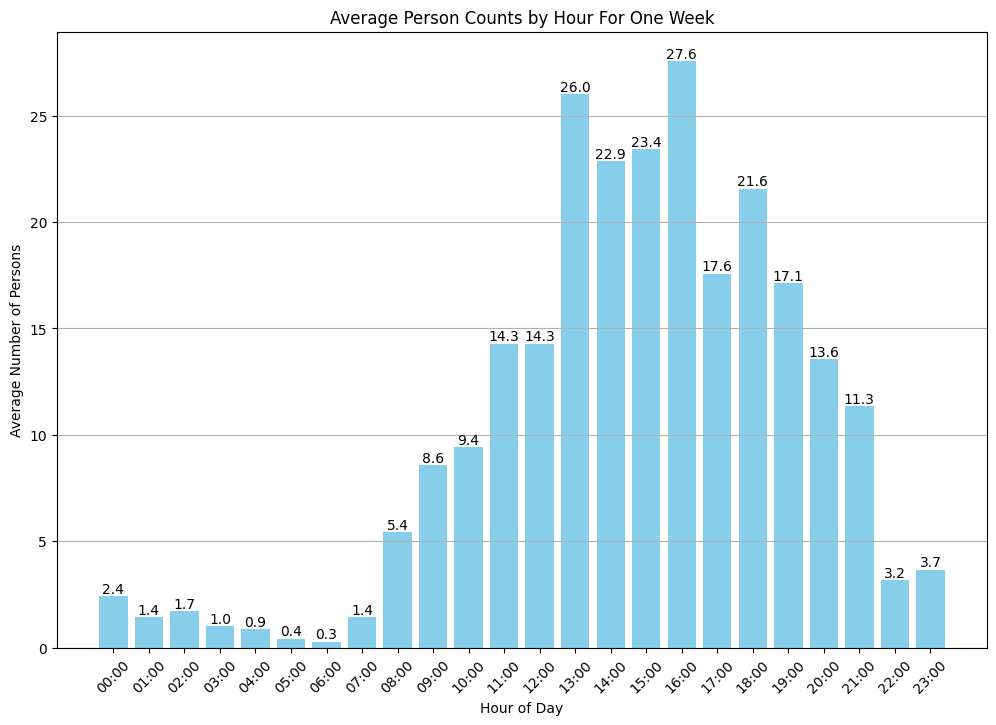

    hour     count
0      0  0.000000
1      1  0.000000
2      2  0.000000
3      3  0.285714
4      4  0.000000
5      5  0.142857
6      6  0.000000
7      7  2.000000
8      8  3.000000
9      9  4.285714
10    10  2.285714
11    11  3.000000
12    12  2.142857
13    13  3.142857
14    14  2.857143
15    15  3.285714
16    16  2.142857
17    17  2.571429
18    18  2.000000
19    19  1.285714
20    20  1.000000
21    21  0.666667
22    22  0.166667
23    23  0.000000


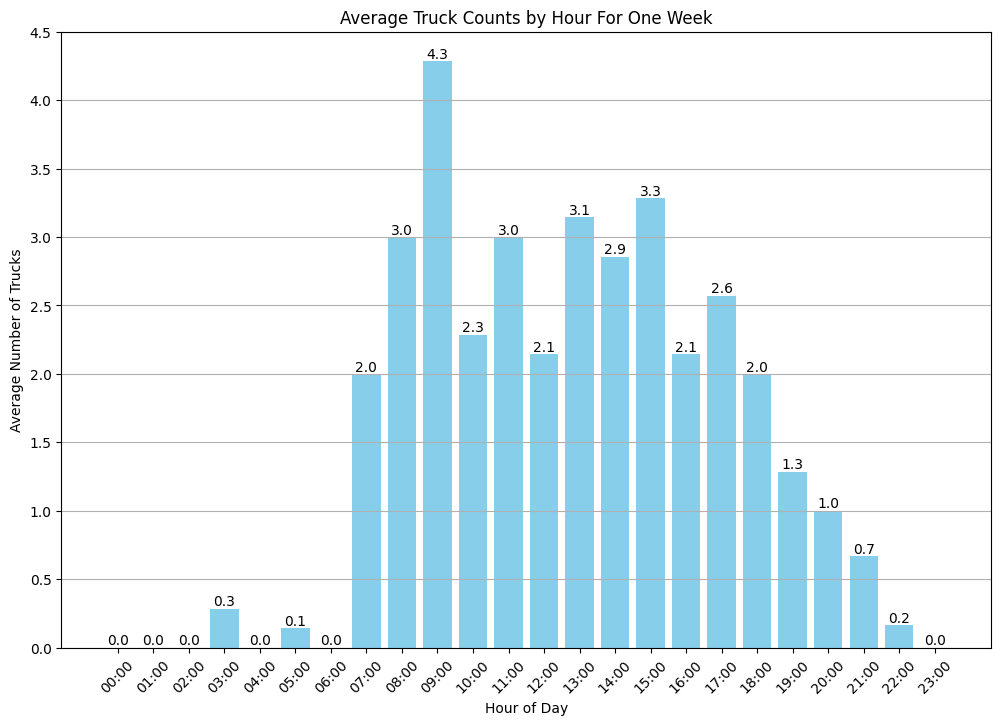

In [128]:
# Ensure all hours from 00 to 23 are represented in the data
all_hours = pd.DataFrame({'hour': range(24)})

for category in interested_objects:
    timestamps, counts = zip(*object_counts[category])  # Extract data for the current category
    
    data = {'timestamp': timestamps, 'count': counts}
    df = pd.DataFrame(data)
    
    # Convert timestamps to pandas datetime objects and extract date and hour
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # Calculate the average count per hour across all dates for the current category
    daily_hourly_counts = df.groupby(['date', 'hour'])['count'].sum().reset_index()
    average_hourly_counts = daily_hourly_counts.groupby('hour')['count'].mean().reset_index()
    
    # Merge with all_hours to ensure every hour is represented
    average_hourly_counts = pd.merge(all_hours, average_hourly_counts, on='hour', how='left').fillna(0)

    # Plotting as a bar chart for the current category
    plt.figure(figsize=(12, 8))
    bars = plt.bar(average_hourly_counts['hour'], average_hourly_counts['count'], color='skyblue')
    
    plt.xlabel('Hour of Day')
    plt.ylabel(f'Average Number of {category.capitalize()}s')
    plt.title(f'Average {category.capitalize()} Counts by Hour For One Week')
    plt.xticks(range(24), [f"{hour:02d}:00" for hour in range(24)], rotation=45)
    plt.grid(axis='y')  # Display horizontal grid lines for better readability

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, "{:.1f}".format(yval), va='bottom', ha='center')
    print(average_hourly_counts)
    
    plt.show()


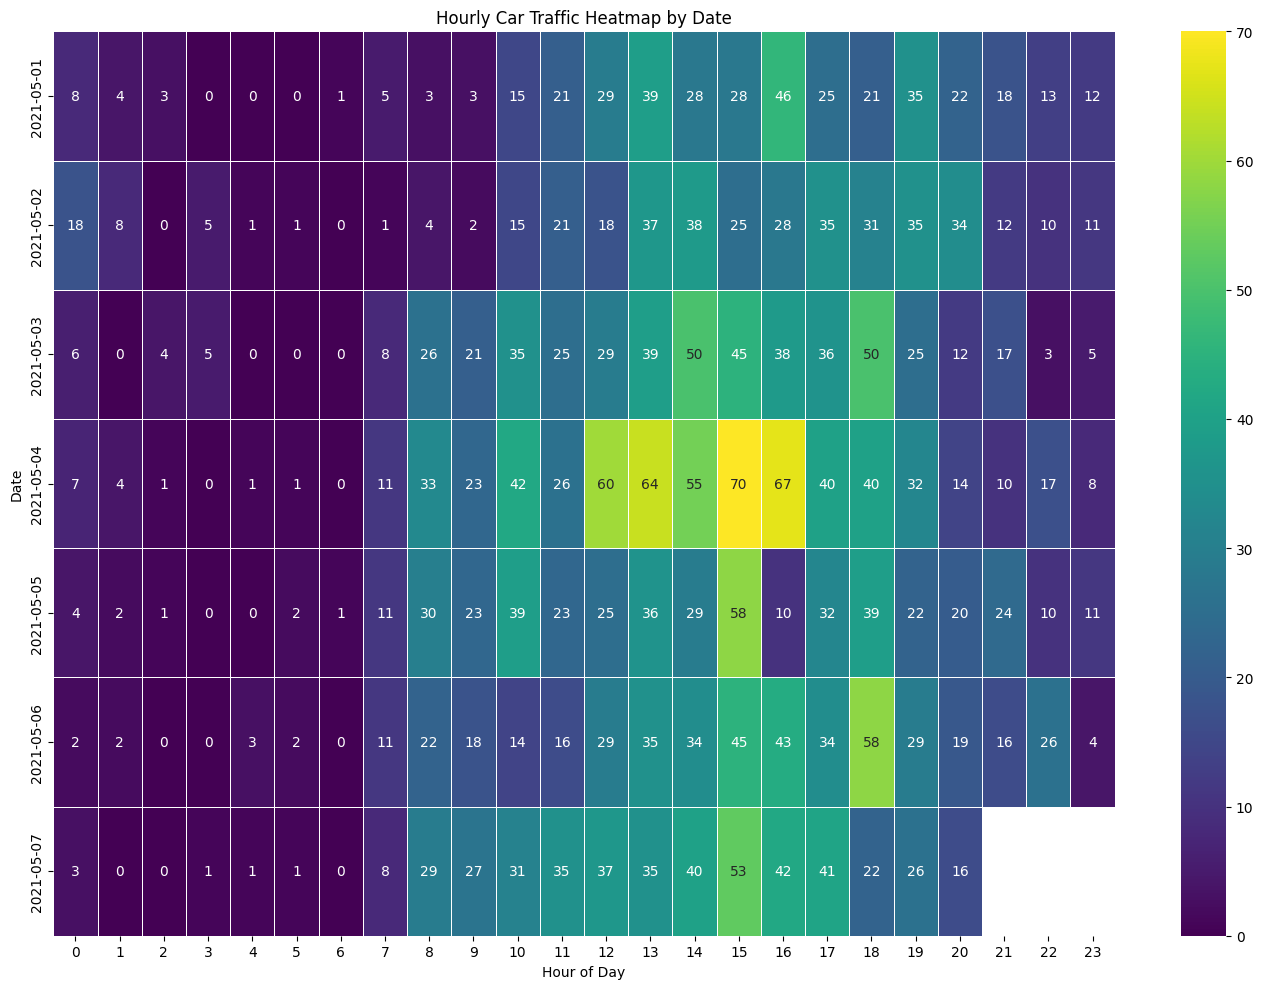

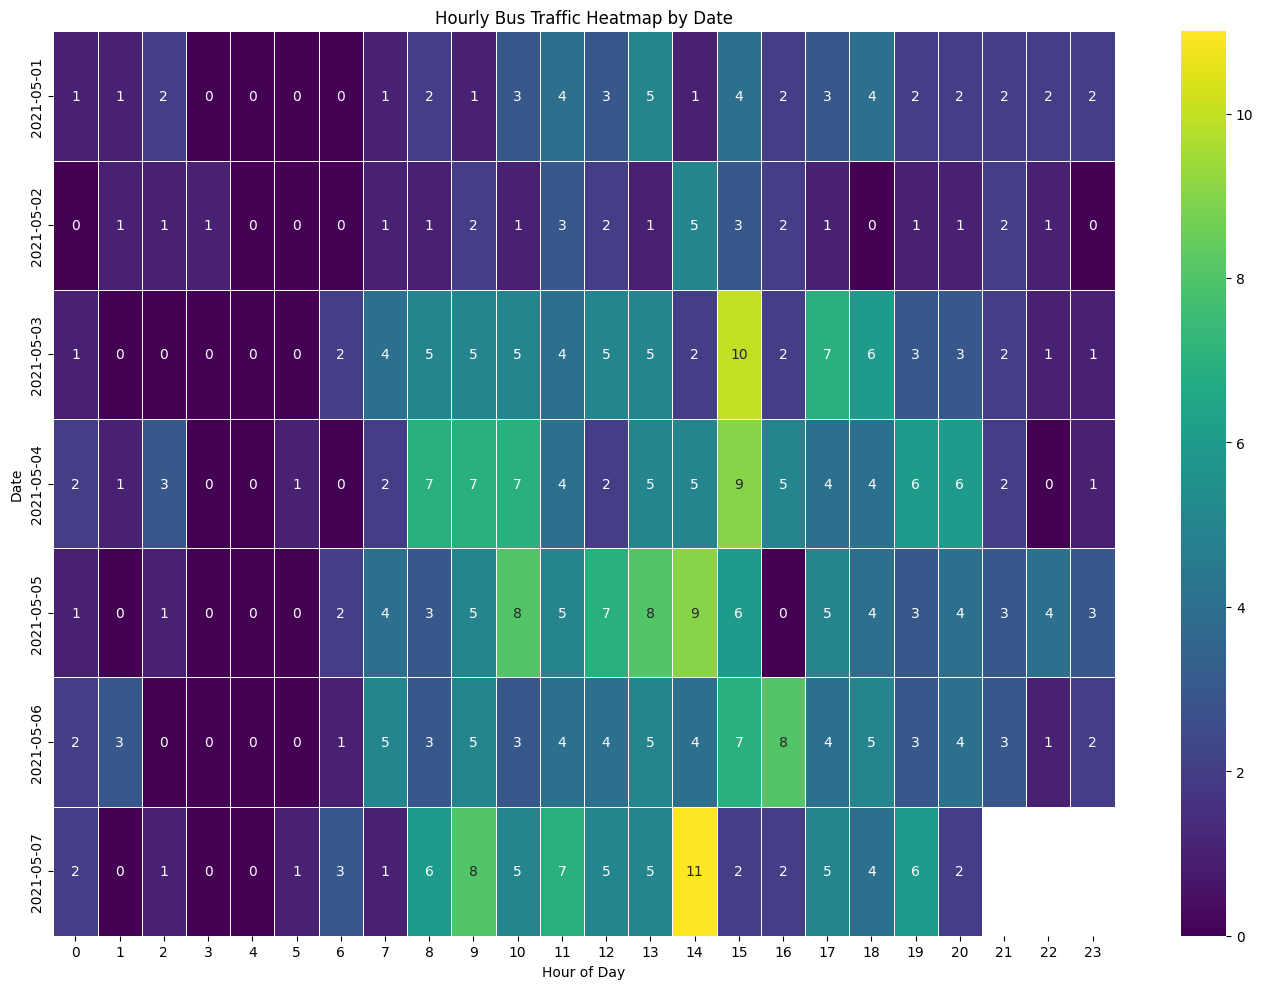

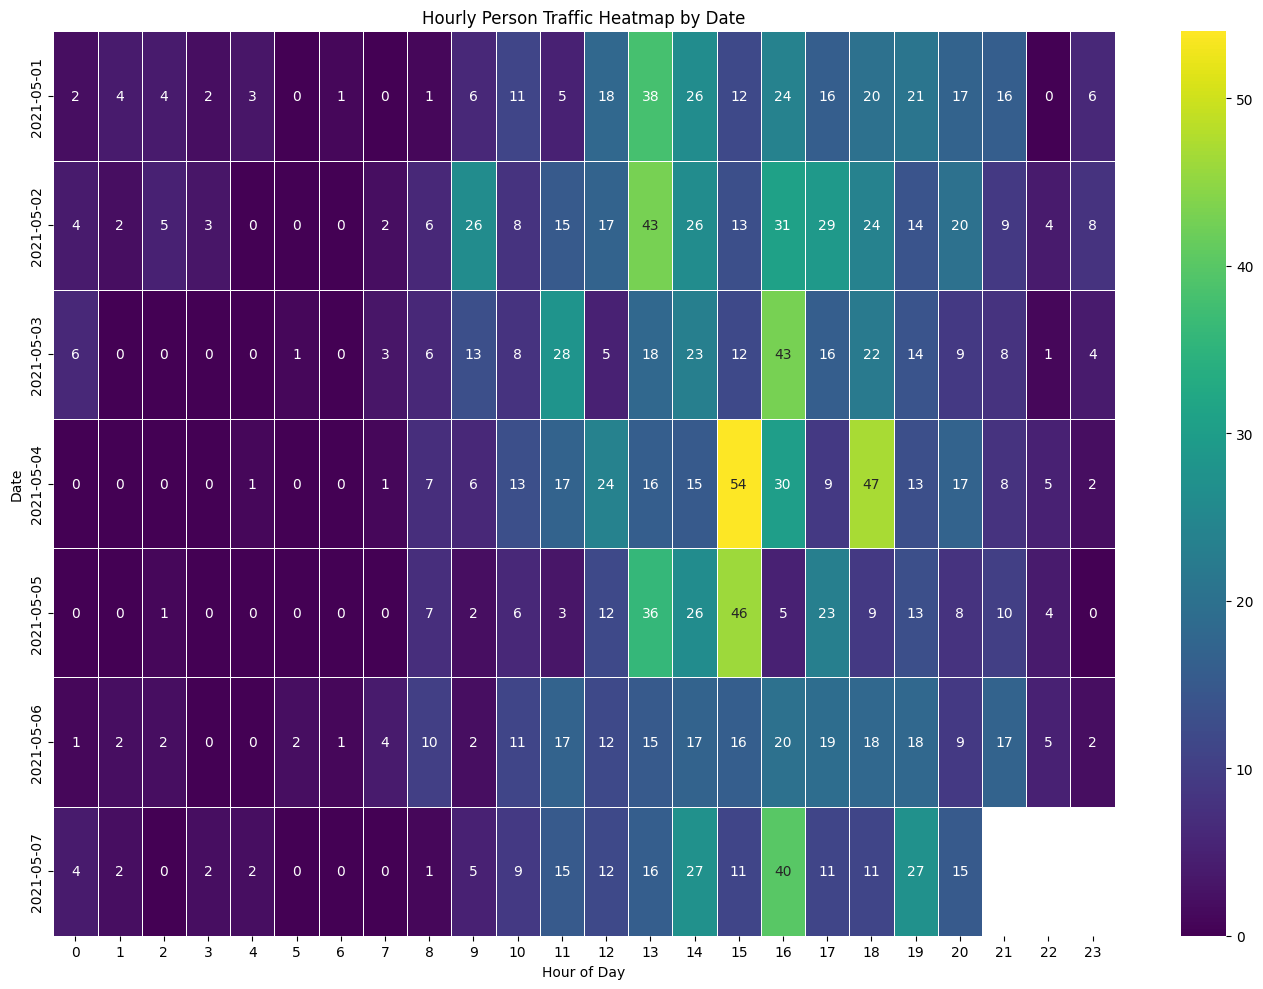

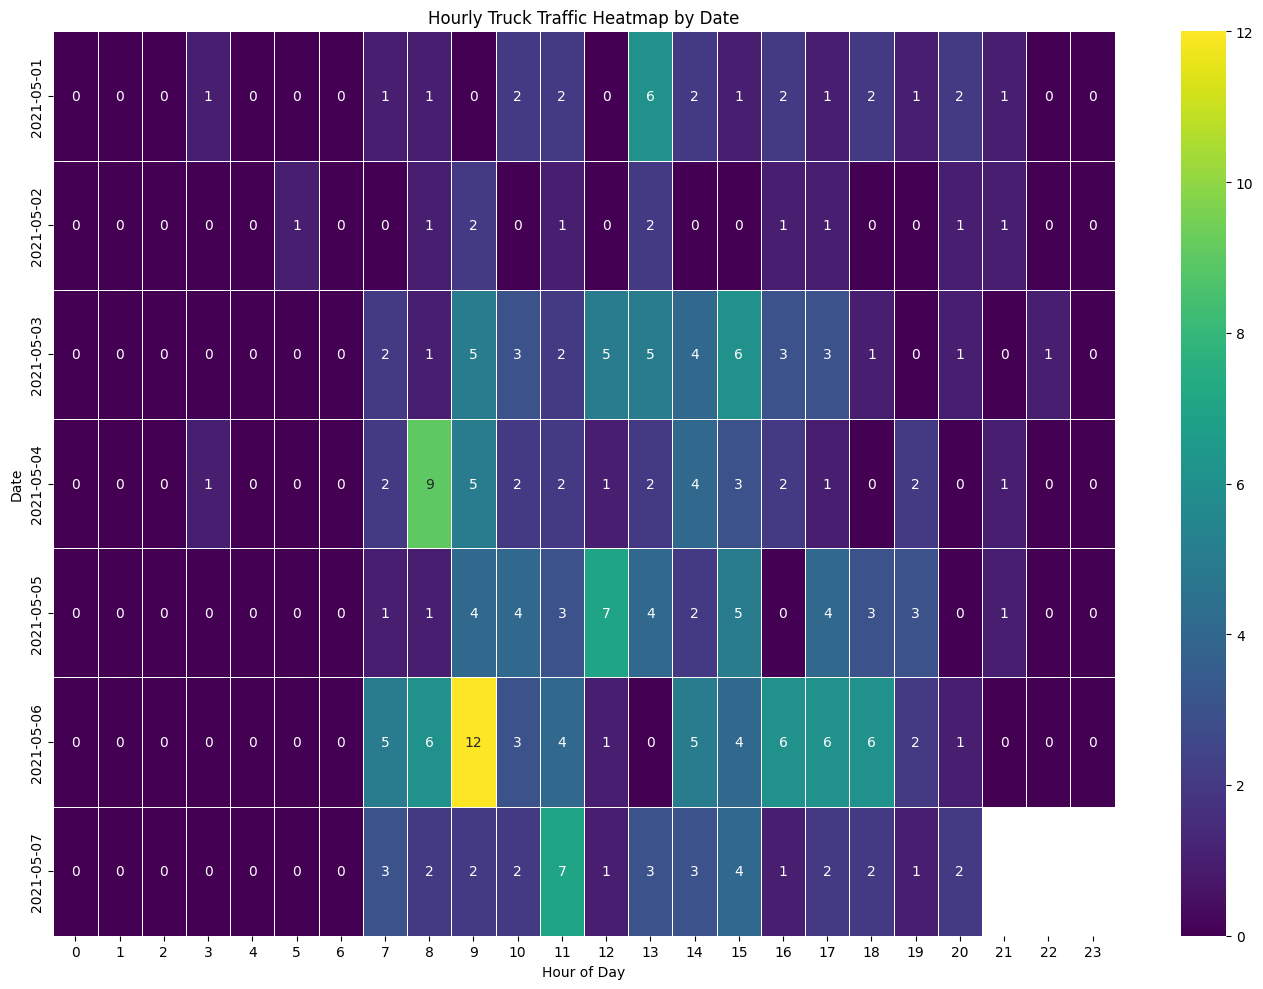

In [47]:
for category in interested_objects:
    # Extract timestamps and counts for the current category
    timestamps, counts = zip(*object_counts[category])

    # Create a DataFrame for the current category
    df = pd.DataFrame({'timestamp': timestamps, 'count': counts})
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract date and hour from the timestamp
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # Create a pivot table for the heatmap
    heatmap_data = df.pivot_table(values='count', index='date', columns='hour', aggfunc='sum')

    # Plotting the heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".0f", linewidths=.5)
    plt.title(f'Hourly {category.capitalize()} Traffic Heatmap by Date')
    plt.xlabel('Hour of Day')
    plt.ylabel('Date')
    plt.tight_layout() 
    plt.show()


2021-05-01 09:12:19


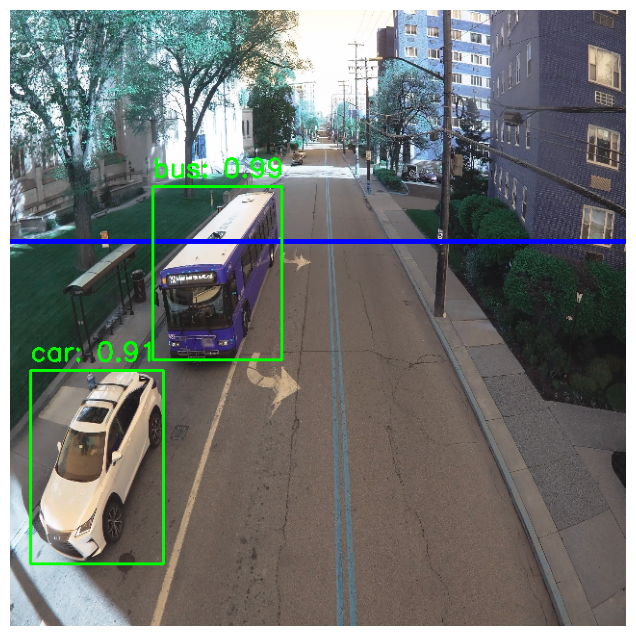

In [132]:
def draw_boxes_with_borderline(image, boxes, labels, scores, threshold=0.5, borderline_y=240):

    image = np.array(to_pil_image(image)) if not isinstance(image, np.ndarray) else image
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Draw the borderline
    cv2.line(image, (0, borderline_y), (image.shape[1], borderline_y), (255, 0, 0), 3)  # Blue line
    
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x1, y1, x2, y2 = box.int().tolist()
            
            # Check if the object is below or intersects the borderline (adjust logic as needed)
            if y1 > borderline_y or y2 > borderline_y:
                label_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, f'{label_name}: {score:.2f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# Example usage for the first image in a batch
image, _ = dataset[0] 
outputs = model([image.to(device)])
draw_boxes_with_borderline(image, outputs[0]['boxes'], outputs[0]['labels'], outputs[0]['scores'], threshold=0.5)
